## ViEWS with random forest
- no lag
- and with lag 
- country codes [here](https://www.uky.edu/~clthyn2/replace_ccode_country.do)

In [44]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import sys
sys.path.append("/Users/kaylahuang/Desktop/GitHub/conflicts/components/")
sys.path.append("/Users/kaylahuang/Desktop/GitHub/conflicts/yun_ff/")

from views_cleaner import VIEWSCleaner

import enums

In [45]:
filename = '../data/views23/features/cm/cm_features.parquet'
gw_id = 780
country = "sri_lanka"

# # not a complete list 
# countries_df = pd.read_csv('../data/views23/countries.csv')
# country_name = countries_df.loc[countries_df['id'] == gw_id, 'name'].values[0]
# print(f"The country with id {gw_id} is {country_name}")


(412, 100)


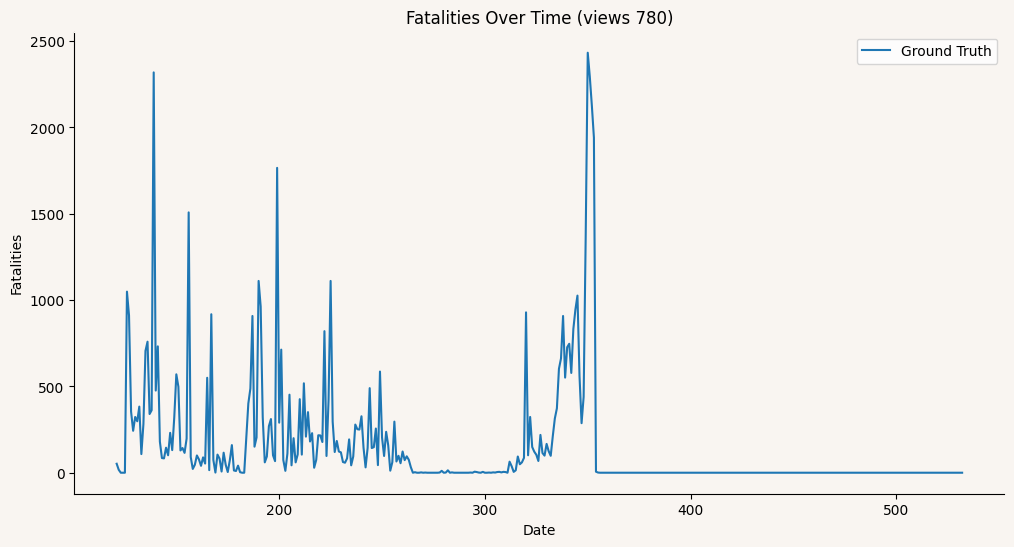

In [46]:
cleaner = VIEWSCleaner(filename, gw_id)
original_features = cleaner.features # already aggregated by month
X = original_features.copy()
print(X.shape)
cleaner.plot()

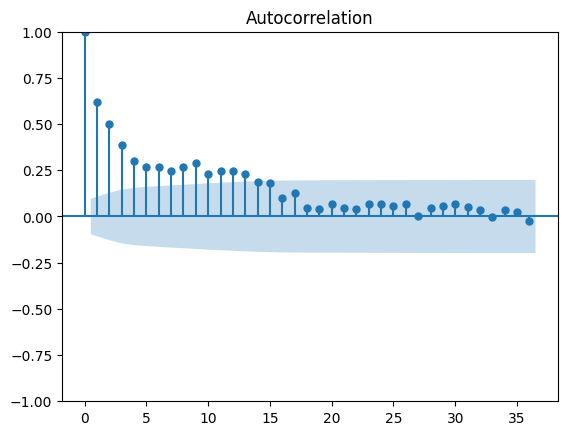

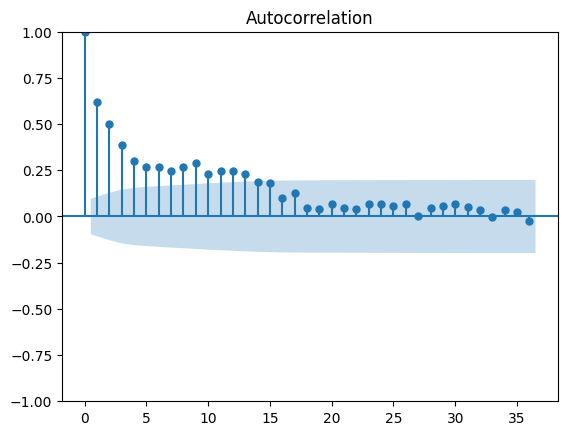

In [47]:
# look at the autocorrelation for each time series 
# to determine the number of lags to take

from statsmodels.graphics.tsaplots import plot_acf
plot_acf(X['ged_sb'], lags=36) 

In [48]:
def create_sliding_window(data, window_size):
    for i in range(1, window_size + 1):
        data[f'lag_{i}'] = data['ged_sb'].shift(i)
    return data.dropna()

window_size = 4 # dictated by the above
X = create_sliding_window(X, window_size)
X.head() # last WINDOW_SIZE columns are the lags

,month_id,country_id,gleditsch_ward,ged_sb,wdi_sp_pop_totl,wdi_ag_lnd_frst_k2,wdi_dt_oda_odat_pc_zs,wdi_ms_mil_xpnd_gd_zs,wdi_ms_mil_xpnd_zs,wdi_nv_agr_totl_kd,...,irr_agr_efficiency_t48,services_efficiency_t48,general_efficiency_t48,water_stress_t48,renewable_internal_pcap_t48,renewable_pcap_t48,lag_1,lag_2,lag_3,lag_4
762,125,121,780,0,17106752.0,23503.3,31.651831,1.798595,7.506662,3.215882e+09,...,0.155267,37.365132,3.114259,68.506311,3217.774009,3217.774009,0.0,0.0,17.0,52.0
931,126,121,780,1049,17106752.0,23503.3,31.651831,1.798595,7.506662,3.215882e+09,...,0.155267,37.365132,3.114259,68.506311,3217.774009,3217.774009,0.0,0.0,0.0,17.0
1098,127,121,780,911,17106752.0,23503.3,31.651831,1.798595,7.506662,3.215882e+09,...,0.155267,37.365132,3.114259,68.506311,3217.774009,3217.774009,1049.0,0.0,0.0,0.0
1265,128,121,780,354,17106752.0,23503.3,31.651831,1.798595,7.506662,3.215882e+09,...,0.155267,37.365132,3.114259,68.506311,3217.774009,3217.774009,911.0,1049.0,0.0,0.0
1432,129,121,780,243,17106752.0,23503.3,31.651831,1.798595,7.506662,3.215882e+09,...,0.155267,37.365132,3.114259,68.506311,3217.774009,3217.774009,354.0,911.0,1049.0,0.0


In [49]:
# ADDING VARS: set war var
war_dates = enums.WAR_DATES.get(country)
if war_dates:
    cleaner.set_war_var(X, war_dates)

X = cleaner.features_war_dates
print(X.shape)

[(43, 91), (126, 181), (184, 266), (319, 353)]
(408, 106)


[1, 14, 31, 42, 62, 65, 74, 100, 195, 213, 220, 225]
       Month  Peak Value
931      126        1049
3095     139        2319
6172     156        1508
8217     167         918
11946    187         908


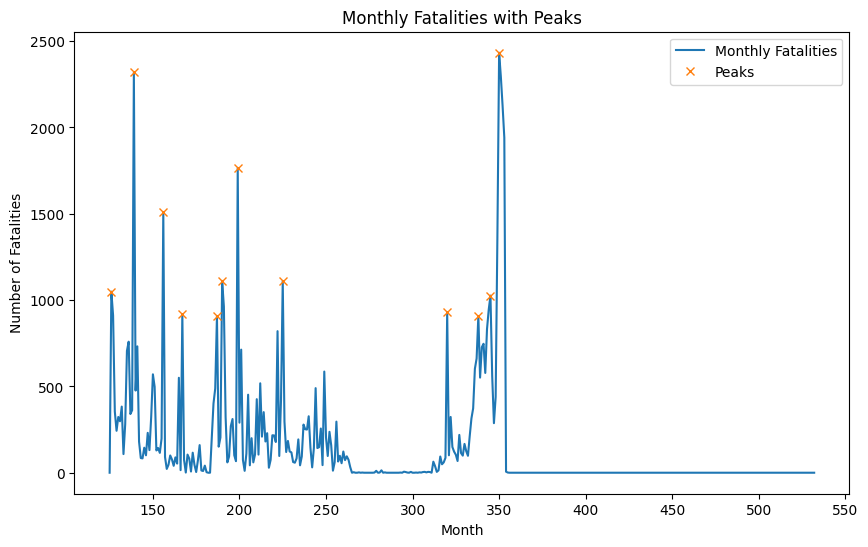

In [50]:
# ADDING VARS: set peak var w poisson process
from scipy.signal import find_peaks

data = X['ged_sb'].copy()
data = pd.Series(data)


height_threshold = data.mean() + 2 * data.std()
peaks, _ = find_peaks(data, height=height_threshold)

# TODO can use moving average
# df = X.copy()
# window_size = 3
# df['moving_avg'] = df['ged_sb'].rolling(window=window_size).mean()
# peaks, _ = find_peaks(df['ged_sb'], height=df['moving_avg'])
  
peak_indices = list(peaks)
print(peak_indices)

peaks_df = pd.DataFrame({
    'Month': X['month_id'].iloc[peak_indices],
    'Peak Value': data.iloc[peak_indices]
})

print(peaks_df.head())

# Plot the data and peaks
plt.figure(figsize=(10, 6))
plt.plot(X["month_id"], data, label='Monthly Fatalities')
plt.plot(peaks_df["Month"], peaks_df["Peak Value"], "x", label='Peaks')
plt.title('Monthly Fatalities with Peaks')
plt.xlabel('Month')
plt.ylabel('Number of Fatalities')
plt.legend()
plt.show()

In [51]:
## POISSON PROCESS CODE
import numpy as np
import pandas as pd
from scipy.signal import find_peaks

# calculate inter-peak intervals
inter_peak_intervals = np.diff(peaks)

# estimate average time between peaks (lambda)
lambda_est = 1 / np.mean(inter_peak_intervals)

# model the poisson process
def poisson_process_prob(t, lambda_est):
    return 1 - np.exp(-lambda_est * t)

# est the probability of future peaks
future_months = np.arange(1, 25)  # Example: next 24 months
probabilities = poisson_process_prob(future_months, lambda_est)
print(probabilities)

# Create a new column "peak_prob" in X
X['peak_prob'] = X['since_war_start'].apply(lambda t: poisson_process_prob(t, lambda_est))


[0.04792088 0.09354536 0.13698347 0.17833998 0.21771466 0.25520246
 0.29089382 0.32487481 0.35722741 0.38802964 0.4173558  0.44527663
 0.47185946 0.49716842 0.52126456 0.54420598 0.56604803 0.5868434
 0.60664223 0.62549228 0.64343902 0.66052574 0.67679364 0.69228198]


In [52]:
# # STANDARDIZATION APPROACH
# from sklearn.preprocessing import StandardScaler
# from sklearn.feature_selection import VarianceThreshold

# def remove_low_variance_features(df, threshold=0.01):
#     scaler = StandardScaler()
#     df_standardized = scaler.fit_transform(df)
    
#     selector = VarianceThreshold(threshold=threshold)
#     selector.fit(df_standardized)
    
#     features_kept = df.columns[selector.get_support(indices=True)]
#     df_reduced = df[features_kept]
#     return df_reduced

# threshold = 0.01  
# df_reduced = remove_low_variance_features(X, threshold)

# print(X.shape)
# print(df_reduced.shape)

In [53]:
# COEFFICIENT OF VARIATION APPROACH

def remove_low_variance_features_cv(df, threshold=0.01):
    cv = df.std() / df.mean()
    features_kept = cv[cv > threshold].index
    df_reduced = df[features_kept]
    return df_reduced

threshold = 0.01
df_reduced = remove_low_variance_features_cv(X, threshold)

print(X.shape)
print(df_reduced.shape)
print("Columns removed:\n", set(X.columns) - set(df_reduced.columns))

X = df_reduced

(408, 107)
(408, 91)
Columns removed:
 {'splag_wdi_sm_pop_refg_or', 'vdem_v2clrgunev', 'splag_wdi_ag_lnd_frst_k2', 'wdi_se_enr_prsc_fm_zs', 'splag_vdem_v2x_accountability', 'splag_vdem_v2x_libdem', 'splag_wdi_sl_tlf_totl_fe_zs', 'country_id', 'gleditsch_ward', 'splag_wdi_sm_pop_netm', 'groundwater_export_t48', 'splag_vdem_v2xpe_exlsocgr', 'wdi_sm_pop_netm', 'wdi_sp_urb_totl_in_zs', 'splag_vdem_v2xcl_dmove', 'splag_vdem_v2xcl_rol'}


In [98]:
import xgboost as xgb
from sklearn.linear_model import ElasticNet, Lasso, Ridge, LogisticRegression
from sklearn.svm import SVR
# from lightgbm import LGBMRegressor


def predict_date(input_month, model_name='RF'):
    ## TRAINING DATA
    pre_date = X[X['month_id'] < input_month].tail(36)
    X_train = pre_date.drop(columns=["ged_sb", "month_id"]) # last 36
    y_train = pre_date["ged_sb"] # corresponding fatalities

    ## MODEL SELECTION AND FIT
    model = None
    if model_name == 'RF':
        model = RandomForestRegressor(n_estimators=100, random_state=42)
    elif model_name == 'XGB':
        model = xgb.XGBRegressor(n_estimators=100, random_state=42)
    elif model_name == 'EN':
        model = ElasticNet(alpha=1.0, l1_ratio=0.1, max_iter=1000, random_state=40)
    # elif model_name == 'SVM':
    #     model = SVR(C=10, epsilon=0.1)
    # elif model_name == 'LGBM':
    #     model = LGBMRegressor(n_estimators=100, random_state=42)
    elif model_name == 'Lasso':
        model = Lasso(alpha=1.0, max_iter=1000, random_state=42)
    elif model_name == 'Ridge':
        model = Ridge(alpha=1.0, max_iter=1000, random_state=42)
    # elif model_name == 'Logistic':
    #     model = LogisticRegression(max_iter=1000, random_state=42)
        
    model.fit(X_train, y_train)
    
    ## MODEL PREDICTION
    row = X[X['month_id'] == input_month]
    prediction = model.predict(row.drop(columns=["ged_sb", "month_id"]))
    
    if model_name in ['EN', 'Lasso', 'Ridge']:
        prediction = np.clip(prediction, a_min=0, a_max=None)
        
    importances = []
    if model_name in ['RF', 'XGB']:
        importances = model.feature_importances_
    
    return prediction[0], row["ged_sb"].values[0], importances

# set the prediction function
prediction_function = lambda date: predict_date(date, model_name='EN')



In [104]:
def ensemble_prediction(input_month):
    models = ['RF', 'XGB', 'Ridge']
    base_predictions = []
    actual_values = []
    
    # Adjust to use data only from months prior to the input_month
    for model in models:
        pred, actual, imp = predict_date(input_month - 1, model_name=model)
        base_predictions.append(pred)
        actual_values.append(actual)
    
    # Assuming base_predictions are used as features for the meta model
    # Meta model could be a simple linear regression for combining predictions
    from sklearn.linear_model import LinearRegression
    meta_model = LinearRegression()
    
    # Reshape base_predictions for training the meta model
    # Here we assume all actual values are the same (as they should be for the same input_month)
    X_meta = np.array(base_predictions).reshape(1, -1)
    y_meta = np.array(actual_values[0]).reshape(-1)
    
    # Fit the meta model
    meta_model.fit(X_meta, y_meta)
    
    # Use the meta model to make the final prediction
    final_prediction = meta_model.predict(X_meta)[0]
    
    imp = 0  # No feature importances from meta model in this simple case
    return final_prediction, actual_values[0], imp


In [105]:
# calculate importances 
month = 200
WIDTH = 5

importances_list = [] 

for m in range(month, month+WIDTH):
    # p, true, feature_imp = prediction_function(m)
    p, true, feature_imp = ensemble_prediction(m)
    print("prediction: ", p)
    print("true: ", true)
    importances_list.append(feature_imp)

/Users/kaylahuang/opt/anaconda3/envs/c-network/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:239: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/Users/kaylahuang/opt/anaconda3/envs/c-network/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:239: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


prediction:  290.0
true:  290
prediction:  713.0
true:  713


/Users/kaylahuang/opt/anaconda3/envs/c-network/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:239: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


prediction:  74.0
true:  74


/Users/kaylahuang/opt/anaconda3/envs/c-network/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:239: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


prediction:  11.0
true:  11
prediction:  111.0
true:  111


/Users/kaylahuang/opt/anaconda3/envs/c-network/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:239: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


In [78]:
# # plotting feature importance for one model 
# importances = feature_imp
# feature_names = X.drop(columns=["ged_sb"]).columns

# # Get the threshold for the top 25% important features
# threshold = np.percentile(importances, 75)
# filtered_importances = importances[importances >= threshold]
# filtered_feature_names = feature_names[importances >= threshold]

# plt.figure(figsize=(10, 6))
# plt.barh(filtered_feature_names, filtered_importances)
# plt.xlabel('Feature Importance')
# plt.ylabel('Feature Names')
# plt.title('Top 25% Feature Importances')
# plt.show()

In [86]:
TOP_N = 10
feature_names = X.drop(columns=["ged_sb", "month_id"]).columns

# Create a DataFrame to store feature importances from all models
importance_df = pd.DataFrame(importances_list, columns=feature_names)

# Calculate the mean importance for each feature across all models
mean_importances = importance_df.mean(axis=0)

# Get the top 5 features based on mean importance
top_features = mean_importances.nlargest(TOP_N).index

print(list(top_features))
top_importances = importance_df[top_features]

plt.figure(figsize=(10, 6))
bar_width = 0.1

# positions for the bars
positions = np.arange(len(top_features))

# model's feature importances next to each other
for i, importances in enumerate(importances_list):
    plt.barh(positions + i * bar_width, top_importances.iloc[i], bar_width, alpha=0.5, label=f'Model {i+1}')

# y ticks in the middle of the grouped bars
plt.yticks(positions + bar_width * (len(importances_list) - 1) / 2, top_features)

plt.xlabel('Feature Importance')
plt.ylabel('Feature Names')
plt.title(f'top {TOP_N} features for country code {gw_id}')
plt.legend()
plt.show()



ValueError: 89 columns passed, passed data had 0 columns

In [95]:
dates_to_predict = X['month_id'].values[100:]

ground_truth = []
predictions = []

for date in dates_to_predict:
    p, t, feature_imp = prediction_function(date)
    ground_truth.append(t)
    predictions.append(p)

plt.figure(figsize=(10, 6))

plt.plot(dates_to_predict, ground_truth, label='Actual', marker='o')
plt.plot(dates_to_predict, predictions, label='Predicted', marker='x')
plt.legend(['Ground Truth', 'Prediction'])
plt.show()


/Users/kaylahuang/opt/anaconda3/envs/c-network/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/kaylahuang/opt/anaconda3/envs/c-network/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_

ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 0

In [ ]:
from sklearn.metrics import r2_score

variance_ged_sb = np.var(original_features['ged_sb'])
print("Variance of fatalities: ", round(variance_ged_sb, 4))

mse = mean_squared_error(ground_truth, predictions)
print("MSE: ", round(mse, 4)) 

r2 = r2_score(ground_truth, predictions)
print("R^2 Score: ", round(r2, 4))  

#  =1: Perfect model with no error.
#  =0: Model does no better than the mean of the target variable.
#  <0: Model performs worse than simply predicting the mean of the target variable.

Variance of fatalities:  114423.1832
MSE:  64366.8118
R^2 Score:  0.3205


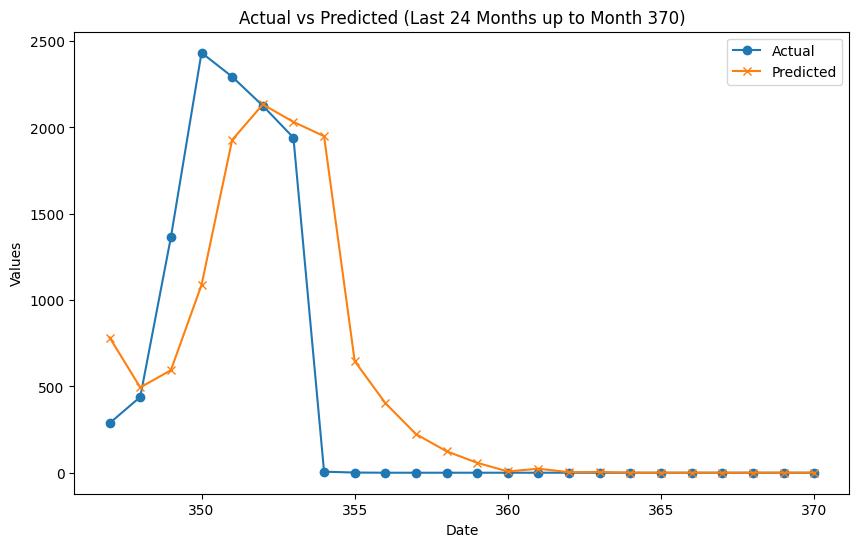

In [57]:
# Define the window size
window_size = 24

# function to plot the last 'window_size' data points from a given month
def plot_last_window_from_month(month, window_size):
    if month in dates_to_predict:
        month_index = list(dates_to_predict).index(month)
        
        # Ensure there are enough data points
        if month_index + 1 >= window_size:
            # Select the last 'window_size' data points up to the given month
            window_dates = dates_to_predict[month_index + 1 - window_size:month_index + 1]
            window_ground_truth = ground_truth[month_index + 1 - window_size:month_index + 1]
            window_predictions = predictions[month_index + 1 - window_size:month_index + 1]

            # Plot the smaller subset
            plt.figure(figsize=(10, 6))
            plt.plot(window_dates, window_ground_truth, label='Actual', marker='o')
            plt.plot(window_dates, window_predictions, label='Predicted', marker='x')
            plt.xlabel('Date')
            plt.ylabel('Values')
            plt.title(f'Actual vs Predicted (Last {window_size} Months up to Month {month})')
            plt.legend()
            plt.show()
        else:
            print(f"Not enough data points to create a window of {window_size} months up to month {month}.")
    else:
        print(f"Month {month} is not in the dates to predict.")

# Example usage
plot_last_window_from_month(370, window_size)
